0_0. Prepare data

In [ ]:
!curl -c /tmp/cookies "https://drive.google.com/uc?export=download&id=1AvU1UDSeg4uWfPA8JynjrrNnvg8oa0AZ" > /tmp/intermezzo.html
!curl -L -b /tmp/cookies "https://drive.google.com$(cat /tmp/intermezzo.html | grep -Po 'uc-download-link" [^>]* href="\K[^"]*' | sed 's/\&amp;/\&/g')" > dataset.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3259    0  3259    0     0   9446      0 --:--:-- --:--:-- --:--:--  9419
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2428      0 --:--:-- --:--:-- --:--:--  2428
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  236M    0  236M    0     0   106M      0 --:--:--  0:00:02 --:--:--  220M


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv( "dataset.txt" , sep=r"<-SEPARATOR->", header= 0, index_col= False, dtype="str",  keep_default_na = False )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
!pip install rank_bm25

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp '/content/drive/Shared drives/NeuralSystems_NLP/models/sent2vec_model.bin' '/content'

In [ ]:
#Check if the file is intact
!ls -sh 'sent2vec_model.bin'

8.3G sent2vec_model.bin


In [ ]:
## Install sent2vec
## Installing sent2vec
!git clone https://github.com/epfml/sent2vec.git
!cd sent2vec &&  make && pip install . 

fatal: destination path 'sent2vec' already exists and is not an empty directory.
make: Nothing to be done for 'opt'.
Processing /content/sent2vec
  Created wheel for sent2vec: filename=sent2vec-0.0.0-cp36-cp36m-linux_x86_64.whl size=1126014 sha256=c84ec0003bdf4c22af8cf9bc80bbfd127122012f03f0dfcba0a49679e3f0bde9
  Stored in directory: /tmp/pip-ephem-wheel-cache-a0sfcwt1/wheels/b1/65/d7/f2c679e0086741bea69f0c4478303b6506bbf4c78dea82f565
Successfully built sent2vec
  Found existing installation: sent2vec 0.0.0
    Uninstalling sent2vec-0.0.0:
      Successfully uninstalled sent2vec-0.0.0


In [ ]:
## Load the sent2vec model into RAM
import sent2vec
model = sent2vec.Sent2vecModel()
model.load_model( "sent2vec_model.bin" )

In [ ]:
# install es server
!apt install default-jdk > /dev/null 
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-6.5.4.tar.gz -q --show-progress
!tar -xzf elasticsearch-6.5.4.tar.gz
!chown -R daemon:daemon elasticsearch-6.5.4





elasticsearch-6.5.4 100%[===================>] 108.07M   216MB/s    in 0.5s    


In [ ]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:6 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 Packages [1,372 kB]
Get:13 http:/

In [ ]:
# start server 
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-6.5.4/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )

In [ ]:
# client-side
!pip install elasticsearch -q
from elasticsearch import Elasticsearch
es = Elasticsearch([{'host':'localhost','port':9200}])

In [ ]:
es.ping()

True

0_1 define classes

In [ ]:
##input data as a dataframe
class SearchEngine:
  def __init__(self, df):
    self.df = df
  

  def clean_data(self, doc_id_name, query_name, doc_name):
    '''
    output : numpy array
    '''
    ### clean original dataset (''s and Na s)
    my_df = self.df[[doc_id_name, query_name, doc_name]]
    my_df = my_df[(my_df[query_name]!='') & (my_df[doc_name]!='')]
    my_df = my_df.dropna()
    ### get a ndarray for my_df
    ds = [  [doc_id, query, doc ]   for doc_id, query, doc  in zip( my_df[doc_id_name], my_df[query_name], my_df[doc_name] )]
    ds = np.array(ds)
    return ds

  def preprocess(self, ds):
    import nltk
    from nltk import RegexpTokenizer
    # This tokenizer is simply to use a regular expression "\w+" to remove all characters which are not from the set [0-9A-Za-z]
    # This is not the best one but is very fast. Explore the nltk package for more powerful tokenizer!
    tokenizer = RegexpTokenizer( "\w+" )

    # Use this tokenizer to tokenize the dataset we just created.
    #record[0] is document id
    for record in ds:
      # record[0] = int(record[0])
      record[1] = " ".join(tokenizer.tokenize( record[1].lower()  ))
      record[2] = " ".join(tokenizer.tokenize( record[2].lower()  ))
    
    return ds


  def bm25_predict(self, ds):
    '''
    input : numpy array with the columns 'doc_id', 'queries', 'documents'
    '''
    from rank_bm25 import BM25Okapi
    ids = ds[:,0]
    queries = ds[:,1]
    docs = ds[:,2]
    # build the index for the corpus
    tokenized_corpus = [ doc.split() for doc in docs]
    bm25 = BM25Okapi( tokenized_corpus )
    
    from tqdm import tqdm
    # We first perform 1000 queries and get a record for Knn_ids for each query.
    Knn_ids_record = []
    for query in tqdm(queries, position=0, leave=True):    # tqdm is used to visualize the progress, not mandatory
      doc_scores = bm25.get_scores( query.split() )
      sorted_indeces = np.argsort( -doc_scores )[:20]
      Knn_ids = ids[sorted_indeces]
      Knn_ids_record.append( Knn_ids )
    
    bm25_predicted_ids = np.asarray( Knn_ids_record )
    return bm25_predicted_ids


  # def load_model(self):
  #   import sent2vec
  #   self.sent2vec_model = sent2vec.Sent2vecModel()
  #   self.sent2vec_model.load_model( "sent2vec_model.bin" )

  def normalized_embeddings(self, model, doc_list):
    ### Compute the embedding of each document in the database
    """
    Note that this database should be first cleaned by tokenization, then used to compute embedding
    Since here we want to use title as query to search abstracts, abstracts can be treated as the database, and titles can
    be treated as query set.
    """
    doc_embeddings = []
    for doc in doc_list:
      doc_embeddings.append( model.embed_sentence( doc ) )

    doc_embeddings = np.concatenate( doc_embeddings, axis = 0 )
    # normalize the doc_embeddings
    normalized_embeddings = doc_embeddings
    # In case that there are zero vectors in the embedding matrix, we only normalize the non-zero vectors in the embedding matrix
    non_zero_indices = np.logical_not( np.all( normalized_embeddings == 0 , axis = 1 ) )
    normalized_embeddings[ non_zero_indices ] = normalized_embeddings[ non_zero_indices ]/np.linalg.norm( normalized_embeddings[ non_zero_indices ], axis =1, keepdims=True )
    return normalized_embeddings

  def sent2vec_predict(self, model, normalized_embeddings, ds):    
    """
    input - ds : numpy array with columns 'doc_id', 'queries', 'dcs'
    Evaluate the performance of sent2vec KNN using M@L score and M distribution.
    """
    #First, for each query, compute embedding, normalize, compute cosine sim
    from tqdm import tqdm
    ids = ds[:,0]
    queries = ds[:,1]
    docs = ds[:,2]
    sent2vec_predicted_ids = []

    for query in tqdm(queries, position=0, leave=True):
      query_embedding = model.embed_sentence(query)
      if not np.all( query_embedding ==0  ):
        normalized_query_embedding = query_embedding/np.linalg.norm( query_embedding, axis =1, keepdims=True )
      else:
        normalized_query_embedding = query_embedding

      similarity_list = np.dot(normalized_embeddings, normalized_query_embedding[0])
      sorted_indeces = np.argsort( -similarity_list )[:20]
      Knn_ids = ids[sorted_indeces]
      sent2vec_predicted_ids.append(Knn_ids)

    sent2vec_predicted_ids = np.array(sent2vec_predicted_ids)
    return sent2vec_predicted_ids

##### Hybrid Search #####
  def preprocessor_tokenizer(self, s):
    import nltk
    from nltk import RegexpTokenizer
    tokenizer = RegexpTokenizer( "\w+" )
    from nltk.stem.snowball import SnowballStemmer

    s = s.lower()
    s_list=tokenizer.tokenize(s)
    ## The usage of stemmer is to merge words with the same stem into one word. 
    ## For example "playing" will be converted to "play" insted of being treated as an independent word.
    ## This can help to control the vocabulary size of inverted index, especially when the corpus is large.
    stemmer = SnowballStemmer('english')
    s_list=[stemmer.stem(word) for word in s_list]
    return s_list

  def compute_inverted_index(self, ds):
    from tqdm import tqdm
    def addDocUnigrams(index, doc_id, doc_tokens):
      unique_words_in_doc=set()
      for word in doc_tokens:
        if word not in unique_words_in_doc:
          if word not in index:
            index[word]=np.asarray([], dtype=np.uint32)
          index[word]=np.append(index[word], np.asarray(doc_id, dtype=np.uint32))
          unique_words_in_doc.add(word)

    ## create the inverted index for the abstracts corpus
    ids = ds[:,0]
    queries = ds[:,1]
    docs = ds[:,2]
    count = 0
    inverted_index = dict()
    for doc in tqdm(docs, position=0, leave=True):
      addDocUnigrams( inverted_index, ids[count], self.preprocessor_tokenizer( doc ) )
      count+=1
    return inverted_index

  def select_keywords(self, tokenized_query, inverted_index, N, m ):
    """
    N is the total number of documents in the corpus
    m is the number of keywords to be selected
    """
    unique_token_occurance = {}
    ## for each unique token in the query, count its occurance in the query, which is used for compute the term frequency.
    for token in tokenized_query:
      unique_token_occurance[token] = unique_token_occurance.get( token, 0 ) +1
    assert m <= len( unique_token_occurance )
    tfidf_score_list = []
    unique_token_list = list(unique_token_occurance.keys())
    for token in unique_token_list:
      ## compute term frequency
      tf = unique_token_occurance[token]/ len(tokenized_query)
      ## compute the inverse document frequency
      idf = np.log( N/ ( len( inverted_index.get( token, np.array([], np.uint32) ) ) +1 ) )
      tfidf_score_list.append(tf*idf)
    
    ## select m keywords with highest tf-idf score
    selected_token_ids = np.argsort( tfidf_score_list)[::-1][:m]
    return [  unique_token_list[idx] for idx in  selected_token_ids ]

  def get_doc_id_with_keywords(self, tokenized_query, inverted_index, N, query_id, m, type):
    '''
    Keyword selection by 'and', 'or' logic
    Given a tokenized query and an inverted index, returns a list of candidate document ids
    selected by 'or' logic
    * It removes the already read keywords, so len(tokenized_query) decreases per iteration.
      If not enough of the query is left, we get an AssertionError.
    '''
    keyword_count = 0
    keep_going = True
    doc_id_with_keywords={} #key: keyword, value: ids
    non_keyword_query_id = []
    while keep_going:
      try:
        selected_keywords = self.select_keywords(tokenized_query, inverted_index, N, 1)
      except AssertionError:  #len(query)<m=1
        #print('Query too short. Selecting whole query as keywords. Query id : ', query_id)
        non_keyword_query_id.append(query_id)
        keep_going = False
        selected_keywords = []

      for keyword in selected_keywords:
        if keyword in inverted_index.keys():
          doc_id_with_keywords[keyword] = inverted_index[keyword]
          keyword_count += 1
          
        tokenized_query.remove(keyword)

      keep_going = keep_going and (keyword_count<m)


    candidates = []
    if type == 'or':
      for keyword in doc_id_with_keywords.keys():
        for index in doc_id_with_keywords.get(keyword):
          if index not in candidates:
            candidates.append(index)

    if type == 'and':
      keywords = list(doc_id_with_keywords.keys())
      doc_ids_keyword_0 = list(doc_id_with_keywords.get(keywords[0]))
      candidates = list(doc_id_with_keywords.get(keywords[0]))
      for doc_id in doc_ids_keyword_0:
        for keyword in keywords:
          if doc_id not in doc_id_with_keywords.get(keyword):          
            candidates.remove(doc_id)
            break

    if len(candidates)==0:
      candidates.append(-1)

    return candidates, non_keyword_query_id

  def hybrid_search(self, inverted_index, normalized_embeddings, ds, m=3, type='or'):
    from tqdm import tqdm
    ids = ds[:,0]
    queries = ds[:,1]
    docs = ds[:,2]
    N = len(queries)
    id2count_map = dict((ids[x],x) for x in range(0,N))
    
    count_not_valid = 0
    Knn_ids_record_sent2vec = []
    with_problems = []
    
    for i, query in enumerate(tqdm(queries, position=0, leave=True)):
      tokenized_query = self.preprocessor_tokenizer(query)
      candidates, problem = self.get_doc_id_with_keywords(tokenized_query, inverted_index, N, ids[i], m=3, type=type)
      if candidates[0]==-1: ## problem type 1 : where the intersection of the document ids given by each keyword is empty
        count_not_valid+=1
      if len(problem) > 0:  ## problem type 2 : no keyword from query matches any of the documents
        with_problems.append(problem)

      normalized_candidates = np.array([normalized_embeddings[id2count_map.get(str(x))] for x in candidates if x>-1])
      query_embedding = model.embed_sentence(query)
      if not np.all(query_embedding==0):
        normalized_query_embedding = query_embedding/np.linalg.norm(query_embedding, axis=1, keepdims=True)
      else:
        normalized_query_embedding = query_embedding
      


      if len(normalized_candidates)>0:
        similarity_list = np.dot(normalized_candidates, normalized_query_embedding[0])
        while len(candidates)<20:
          similarity_list = np.append(similarity_list, [-1])
          candidates.append(-1)
        Knn_ids = np.asarray([candidates[x] for x in np.argsort(-similarity_list)[:20]])
        Knn_ids_record_sent2vec.append(Knn_ids)
      else:
        Knn_ids = np.repeat(-1,20)
        Knn_ids_record_sent2vec.append(Knn_ids)

    hybrid_predicted_ids = np.array(Knn_ids_record_sent2vec)
    return hybrid_predicted_ids

    
  def elastic_search(self, ds):
    from tqdm.notebook import tqdm
    ids = ds[:,0]
    queries = ds[:,1]
    docs = ds[:,2]
    ESKnn_ids_record = []
    for query in tqdm(queries):    
      res = es.search(index='testmethod',body={"query":{"query_string" : {"query" : query ,"default_field" : "abstract"}}}, size = 20)
      documents2 = res['hits']['hits']
      df2 = pd.DataFrame(documents2)
      if res['hits']['total'] != 0:
        hits = pd.DataFrame.from_records(df2['_source'])
        hitsindex = list(hits.doc_id)
        while len(hitsindex) < 20:
          hitsindex.append(-1)
        ESKnn_ids_record.append(np.asarray(hitsindex))
      
    ESKnn_ids_record = np.array( ESKnn_ids_record )
    return ESKnn_ids_record





In [ ]:
class Evaluate:
  def __init__(self):
    pass

  def M_at_k(self, predicted_ids, target_ids, k=1):
    import numpy as np
    predicted_ids = predicted_ids.astype('int')
    target_ids = target_ids.astype('int')
    M_k_score = np.mean( np.any( predicted_ids[:,:k] == target_ids[:, np.newaxis], axis=-1 ))
    return M_k_score

  def plot_M_at_ks(self, predicted_ids, target_ids, k=20):
    import numpy as np
    import matplotlib.pyplot as plt

    predicted_ids = predicted_ids.astype('int')
    target_ids = target_ids.astype('int')
    ML_score_list = []
    for L in range(1,k+1):
      ML_score_list.append( np.mean( np.any( predicted_ids[:,:L] == target_ids[:, np.newaxis], axis=-1 )) )

    print( "M@20 score:", ML_score_list[-1] )
    plt.plot( np.arange(1,21), ML_score_list )
    plt.xlabel("L")
    plt.ylabel("M@L score")
    plt.title("M@L score curve")
    plt.xticks( np.arange(1,21) )
    plt.show()

  def plot_M_distribution(self, predicted_ids, target_ids):
    import matplotlib.pyplot as plt
    import numpy as np

    predicted_ids = predicted_ids.astype('int')
    target_ids = target_ids.astype('int')

    rank_order_list =[]
    for idx in range(len(target_ids)):
      if target_ids[idx] in predicted_ids[idx]:
        rank_order_list.append( np.argwhere(  target_ids[idx] == predicted_ids[idx]  )[0,0] )
    plt.hist( rank_order_list, bins=20 )
    plt.show()


  def reciprocal_rank(self, retrieved_id_list, real_id):
    ## input : (a list of retrieved_ids for a query, the query's(or document's) real_id) 
    ## output : a single score for a query
    for i, retrieved_id in enumerate(retrieved_id_list):
      if retrieved_id == real_id:
        return 1/(i+1)
    
    return 0

  def MRR(self, predicted_ids, target_ids):
    import numpy as np

    predicted_ids = predicted_ids.astype('int')
    target_ids = target_ids.astype('int')
    N = len(predicted_ids)
    rr_list = []
    for i in range(0,N):
      retrieved_id_list = predicted_ids[i]
      real_id = target_ids[i]
      rr = self.reciprocal_rank(retrieved_id_list, real_id)
      rr_list.append(rr)

    mrr_score = np.mean(rr_list)
    return mrr_score

##1. title -> abstract

In [ ]:
engine = SearchEngine(df)

In [ ]:
evaluate = Evaluate()

In [ ]:
ds = engine.clean_data('doc_id', 'title', 'abstract')
ds = engine.preprocess(ds)

###1.1 bm25

In [ ]:
bm25_predict = engine.bm25_predict(ds)

100%|██████████| 8573/8573 [08:31<00:00, 16.75it/s]


In [ ]:
print('bm25 M@1 :', evaluate.M_at_k(bm25_predicted, target_id_list))

bm25 M@1 : 0.9433103930945993


In [ ]:
print('bm25 MRR :', evaluate.MRR(bm25_predict, target_id_list))

bm25 MRR : 0.962670863670736


M@20 score: 0.9944010264784789


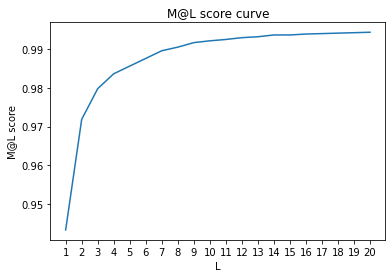

In [ ]:
evaluate.plot_M_at_ks(bm25_predict, target_id_list)

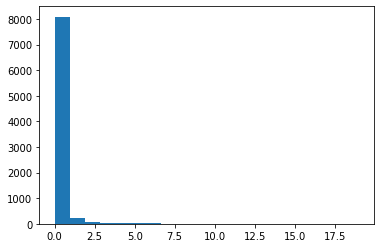

In [ ]:
evaluate.plot_M_distribution(bm25_predict, target_id_list)

###1.2 sent2vec

In [ ]:
doc_list = ds[:,2]

In [ ]:
normalized_embeddings = engine.normalized_embeddings(model, doc_list)

In [ ]:
## RAM almost explodes... why?
sent2vec_predict = engine.sent2vec_predict(model, normalized_embeddings, ds)

100%|██████████| 8573/8573 [00:24<00:00, 356.91it/s]


In [ ]:
print('sent2vec M@1 :', evaluate.M_at_k(sent2vec_predict, ds[:,0]))

sent2vec M@1 : 0.8678408958357634


In [ ]:
print('sent2vec MRR :', evaluate.MRR(sent2vec_predict, ds[:,0]))

sent2vec MRR : 0.9127563699818364


M@20 score: 0.9933512189431938


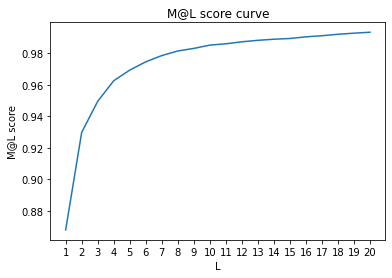

In [ ]:
evaluate.plot_M_at_ks(sent2vec_predict, ds[:,0])

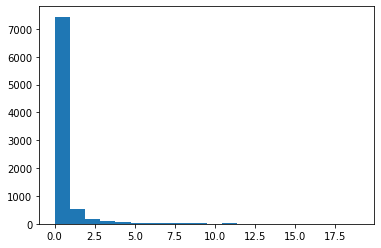

In [ ]:
evaluate.plot_M_distribution(sent2vec_predict, ds[:,0])

###1.3.1 hybrid_or

In [ ]:
inverted_index = engine.compute_inverted_index(ds)

100%|██████████| 8573/8573 [00:31<00:00, 276.37it/s]


In [ ]:
hybrid_or_predict = engine.hybrid_search(inverted_index, normalized_embeddings, ds, type='or')

100%|██████████| 8573/8573 [00:48<00:00, 175.28it/s]


In [ ]:
print('hybrid_or M@1 :', evaluate.M_at_k(hybrid_or_predict, ds[:,0]))

hybrid_or M@1 : 0.8760060655546483


In [ ]:
print('hybrid_or MRR :', evaluate.MRR(hybrid_or_predict, ds[:,0]))

hybrid_or MRR : 0.9191409828094536


M@20 score: 0.9914848944360201


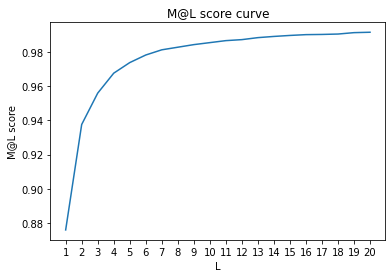

In [ ]:
evaluate.plot_M_at_ks(hybrid_or_predict, ds[:,0])

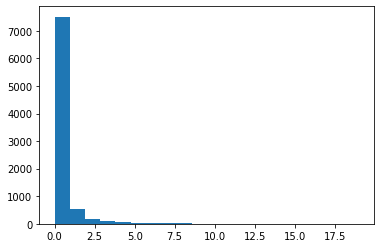

In [ ]:
evaluate.plot_M_distribution(hybrid_or_predict, ds[:,0])

###1.3.2 hybrid_and

In [ ]:
hybrid_and_predict = engine.hybrid_search(inverted_index, normalized_embeddings, ds, type='and')

100%|██████████| 8573/8573 [00:09<00:00, 860.71it/s]


In [ ]:
hybrid_or_predict.shape

(8573, 20)

In [ ]:
hybrid_and_predict.shape

(8573, 20)

In [ ]:
print('hybrid_and M@1 :', evaluate.M_at_k(hybrid_and_predict, ds[:,0]))

hybrid_and M@1 : 0.7055873089933512


In [ ]:
print('hybrid_and MRR :', evaluate.MRR(hybrid_and_predict, ds[:,0]))

hybrid_and MRR : 0.7131372253470702


M@20 score: 0.7226175201213111


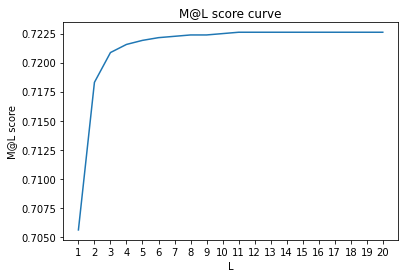

In [ ]:
evaluate.plot_M_at_ks(hybrid_and_predict, ds[:,0])

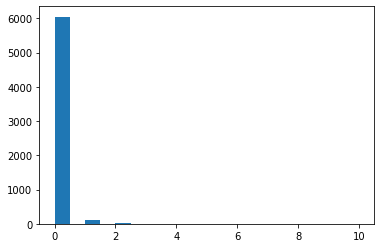

In [ ]:
evaluate.plot_M_distribution(hybrid_and_predict, ds[:,0])

###1.4 Elastic Search

In [ ]:
elastic_predict = engine.elastic_search(ds)

In [ ]:
print('elastic M@1 :', evaluate.M_at_k(elastic_predict, ds[:,0]))

sent2vec M@1 : 0.9433103930945993


In [ ]:
print('elastic MRR :', evaluate.MRR(elastic_predict, ds[:,0]))

elastic MRR : 0.9627567411892498


M@20 score: 0.9945176717601772


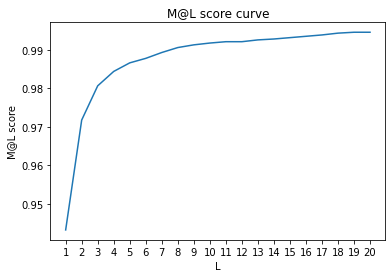

In [ ]:
evaluate.plot_M_at_ks(elastic_predict, ds[:,0])

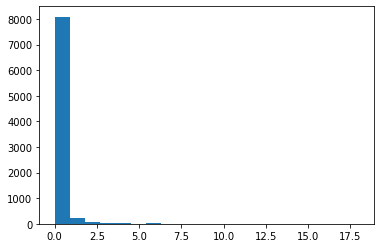

In [ ]:
evaluate.plot_M_distribution(elastic_predict, ds[:,0])

##2 abstract->title

In [ ]:
engine = SearchEngine(df)

In [ ]:
evaluate = Evaluate()

In [ ]:
ds = engine.clean_data('doc_id', 'abstract', 'title')
ds = engine.preprocess(ds)

###2.1 bm25

In [ ]:
bm25_predict_a2t = engine.bm25_predict(ds)

100%|██████████| 8573/8573 [1:00:29<00:00,  2.36it/s]


In [ ]:
print('elastic M@1 :', evaluate.M_at_k(bm25_predict_a2t, ds[:,0]))

elastic M@1 : 0.8432287413974104


In [ ]:
print('elastic MRR :', evaluate.MRR(bm25_predict_a2t, ds[:,0]))

elastic MRR : 0.883541781189212


M@20 score: 0.9647731249270967


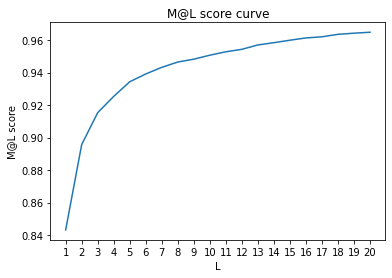

In [ ]:
evaluate.plot_M_at_ks(bm25_predict_a2t, ds[:,0])

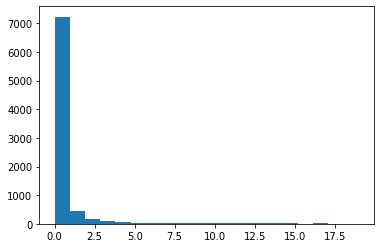

In [ ]:
evaluate.plot_M_distribution(bm25_predict_a2t, ds[:,0])

###2.2 sent2vec

In [ ]:
doc_list = ds[:,2]

In [ ]:
normalized_embeddings = engine.normalized_embeddings(model, doc_list)

In [ ]:
## RAM almost explodes... why?
sent2vec_predict_a2t = engine.sent2vec_predict(model, normalized_embeddings, ds)

100%|██████████| 8573/8573 [00:19<00:00, 445.43it/s]


In [ ]:
print('sent2vec M@1 :', evaluate.M_at_k(sent2vec_predict_a2t, ds[:,0]))

sent2vec M@1 : 0.8191998133675493


In [ ]:
print('bm25 MRR :', evaluate.MRR(sent2vec_predict_a2t, ds[:,0]))

bm25 MRR : 0.8717496577282854


M@20 score: 0.9779540417590108


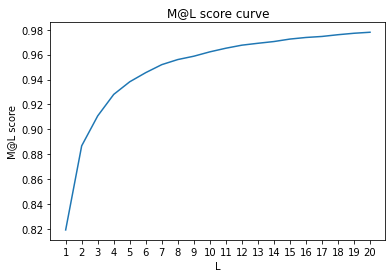

In [ ]:
evaluate.plot_M_at_ks(sent2vec_predict_a2t, ds[:,0])

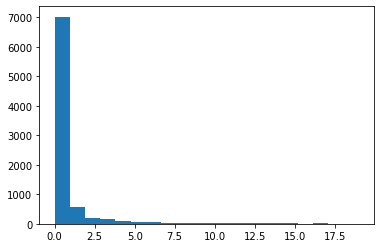

In [ ]:
evaluate.plot_M_distribution(sent2vec_predict_a2t, ds[:,0])

###2.3.1 hybrid_or

In [ ]:
inverted_index = engine.compute_inverted_index(ds)

100%|██████████| 8573/8573 [00:03<00:00, 2822.97it/s]


In [ ]:
hybrid_or_predict_a2t = engine.hybrid_search(inverted_index, normalized_embeddings, ds, type='or')

100%|██████████| 8573/8573 [01:34<00:00, 91.18it/s]


In [ ]:
print('sent2vec M@1 :', evaluate.M_at_k(hybrid_or_predict_a2t, ds[:,0]))

sent2vec M@1 : 0.6850577394144407


In [ ]:
print('bm25 MRR :', evaluate.MRR(hybrid_or_predict_a2t, ds[:,0]))

bm25 MRR : 0.7127590267642475


M@20 score: 0.7592441385745946


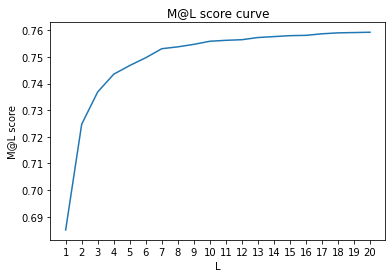

In [ ]:
evaluate.plot_M_at_ks(hybrid_or_predict_a2t, ds[:,0])

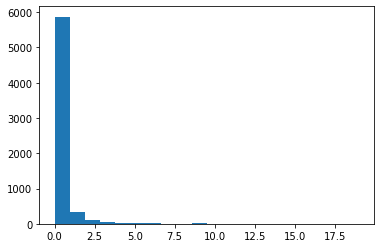

In [ ]:
evaluate.plot_M_distribution(hybrid_or_predict_a2t, ds[:,0])

In [ ]:
# del sent2vec_predict

###2.3.2 hybrid_and

In [ ]:
hybrid_and_predict_a2t = engine.hybrid_search(inverted_index, normalized_embeddings, ds, type='and')

100%|██████████| 8573/8573 [01:05<00:00, 130.63it/s]


In [ ]:
print('sent2vec M@1 :', evaluate.M_at_k(hybrid_and_predict_a2t, ds[:,0]))

sent2vec M@1 : 0.41607371981803337


In [ ]:
print('bm25 MRR :', evaluate.MRR(hybrid_and_predict_a2t, ds[:,0]))

bm25 MRR : 0.42675855423237763


M@20 score: 0.44266884404525836


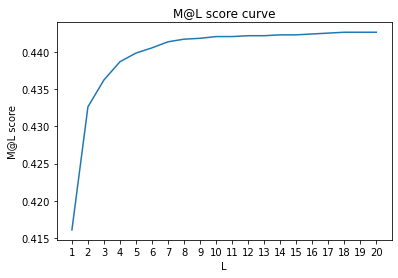

In [ ]:
evaluate.plot_M_at_ks(hybrid_and_predict_a2t, ds[:,0])

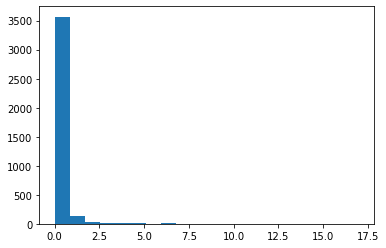

In [ ]:
evaluate.plot_M_distribution(hybrid_and_predict_a2t, ds[:,0])

###2.4 Elastic Search

In [ ]:
elastic_predict_a2t = engine.elastic_search(ds)

In [ ]:
print('elastic M@1 :', evaluate.M_at_k(elastic_predict_a2t, ds[:,0]))

elastic M@1 : 0.9997667094366033


In [ ]:
print('elastic MRR :', evaluate.MRR(elastic_predict_a2t, ds[:,0]))

elastic MRR : 0.9998833547183017


M@20 score: 1.0


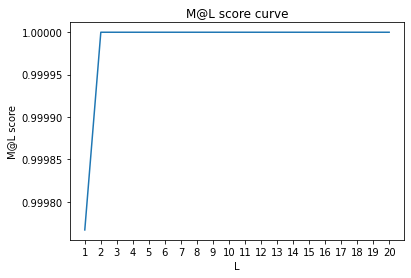

In [ ]:
evaluate.plot_M_at_ks(elastic_predict_a2t, ds[:,0])

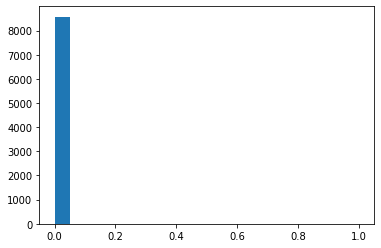

In [ ]:
evaluate.plot_M_distribution(elastic_predict_a2t, ds[:,0])